# Demo 02: View water column data

## Introduction

This Jupyter Notebook contains an introduction to viewing water column data using Ping.

## Here you will learn

- 

## Short version

At the end of the notebook you will find the important parts of this notebook, compiled into a single cell


## ---

### First: Import the necessary modules

In [6]:
# use widgets as matplotlib backend
%matplotlib widget

# imports
from matplotlib import pyplot as plt
import os
import sys
import numpy as np
from collections import defaultdict
from time import time
from tqdm.auto import tqdm #progress bar, auto selects a backend based on the environment e.g. for a jupyter notebook it will use the widget version

from typing import Union, Tuple

import matplotlib as mpl
import matplotlib.dates as mdates

import datetime as dt

# import the file object for opening kongsberg files
# Note: function and library naming to be discussed
from themachinethatgoesping.echosounders import simradraw,kongsbergall          # This is the filereader module for .all/.wcd files
from themachinethatgoesping.echosounders import filetemplates      # This is the filereader module for .all/.wcd files
from themachinethatgoesping.echosounders import pingtools          # This is the filereader module for .all/.wcd files
from themachinethatgoesping.echosounders import index_functions # This is the module for creating and using indexes to speed up file initialization
import themachinethatgoesping.tools as ptools                   # Some tools for working with ping (here we use timeconv for timestamp conversion)
import themachinethatgoesping.algorithms as palgorithms                   # Some tools for working with ping (here we use timeconv for timestamp conversion)
import themachinethatgoesping.navigation as pnav                   # Some tools for working with ping (here we use timeconv for timestamp conversion)

import themachinethatgoesping.pingprocessing.watercolumn.make_image as mi
import themachinethatgoesping.pingprocessing.watercolumn.helper.make_image_helper as mi_hlp

from themachinethatgoesping.pingprocessing import filter_pings, overview, split_pings, group_pings
from themachinethatgoesping.pingprocessing import watercolumn
gp = palgorithms.geoprocessing
import pandas as pd

# simplify creating figures
mpl.rcParams['figure.dpi'] = 100
close_plots: bool = True

def create_figure(name: str, return_ax: bool = True) -> Union[Tuple[plt.Figure, plt.Axes], plt.Figure]:
    """Helper function to create a figure with a given name that returns the figure and axis
    """
    if close_plots:
        plt.close(name)
    fig = plt.figure(name)
    fig.suptitle = name

    if return_ax:
        return fig, fig.subplots()
    return fig

def clear_memory():
    import gc
    gc.collect()
    
    import ctypes
    libc = ctypes.CDLL("libc.so.6") # clearing cache 
    libc.malloc_trim(0)

In [7]:
from collections import OrderedDict

class fake_tqdm(object):
    def __init__(self, w_prg):
        self.w_prg = w_prg
        
    def __call__(self, list_like):
        self.list_like = list_like
        self.list_iter = iter(list_like)
        self.index = 0
        self.total = len(list_like)
        self.w_prg.max = self.total
        self.w_prg.value = 0
        return self
        
    def __iter__(self):
        return self
    
    def __next__(self):
        self.index += 1
        self.w_prg.value = self.index
        return next(self.list_iter)
    
    def __len__(self):
        return self.total
    
    def update(self):
        self.index += 1
        next(self.list_iter)
        self.w_prg.value = self.index
        
    def close(self):
        pass

### Find files to open

This is a simple python loop to find .all and .wcd files in the specified directories

In [15]:
# Define the folder(s) to search for Kongsberg files
# Note: subdirectories will be searched as well
folders = []
#folders.append("./")
#folders.append("/home/users/data/koen campaign 2/")
folders.append("/home/data/turbeams/TURBEAMS 2023-12/")

# Initialize lists for storing file paths and names
files = index_functions.find_files(folders, [".all","wcd"])
files.sort()

file_cache_paths = index_functions.get_cache_file_paths(file_paths=files)

index_functions.remove_name_from_cache(file_cache_paths, "FilePackageCache<RuntimeParameters>")
index_functions.print_cache_file_statistics(file_cache_paths)

Found 122 files


 25%|##4       | 30/122 [00:01<00:03, 28.73it/s]

FilePackageIndex: 192.38 'MB' / 0.45 %
NavigationInterpolatorLatLon: 1654.93 'MB' / 3.84 %
- Combined -: 1847.31 'MB' / 4.29 %
- Source files -: 43059.28 'MB' / 100.0 %


## Open files


In [17]:
file_cache_paths = index_functions.get_cache_file_paths(file_paths=files)

fm = kongsbergall.KongsbergAllFileHandler_mapped(files[:], file_cache_paths=file_cache_paths, init = True)

Error message: 'failed mapping file: Invalid argument: iostream error'


Error message: 'failed mapping file: Invalid argument: iostream error'


indexing files ⢀ 99% :02s<00m:00s] [Found: 7717334 datagrams in 122 files (43059MB)]                                                 
Initializing navigation ⠂ 92% :04s<00m:00s] [60/63]                      
Initializing ping interface ⠂ 98% :26s<00m:01s] [Done]                                              


In [19]:
split_time_s = 30

all_pings = fm.pings()

#split into blocks
times = [ps[0].get_timestamp() for ps in split_pings.by_time_difference(all_pings, split_time_s, True).values()]

ping_containers = split_pings.by_time_blocks(all_pings, times)

ping_containers = {ptools.timeconv.unixtime_to_datestring(k, format='%d-%m-%Y %H:%M:%S') : v for k,v in ping_containers.items()}

stats = overview.get_ping_overview(ping_containers,True)

for k,pings in ping_containers.items():
    print(k,len(pings))

13-12-2023 09:00:09 73962
13-12-2023 21:29:08 54050
14-12-2023 16:03:59 47483
14-12-2023 22:36:32 40981
15-12-2023 16:12:27 75
15-12-2023 16:14:07 300
15-12-2023 17:52:47 21175
15-12-2023 20:52:40 29818
16-12-2023 12:30:18 33930
17-12-2023 00:55:56 34108


13-12-2023 09:00:09 36981
13-12-2023 21:29:08 27025
14-12-2023 16:03:59 23741
14-12-2023 22:36:32 20490
15-12-2023 16:12:27 44
15-12-2023 16:14:07 150
15-12-2023 17:52:47 10588
15-12-2023 20:52:40 14909
16-12-2023 12:30:18 16965
17-12-2023 00:55:56 17054


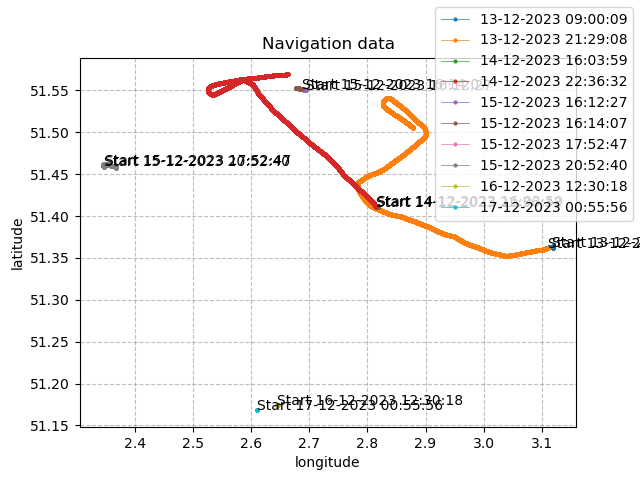

In [22]:
import rasterio.plot as rioplt
import rasterio as rio

#background_map = rio.open('qgis/BPNS_latlon.tiff')

fig,ax = overview.nav_plot.create_figure('Navigation data', aspect='auto')
#rioplt.show(background_map,ax=ax,cmap='Greys_r')

all_stats = defaultdict(list)

for k,pings in ping_containers.items():
    if len(pings) < 10:
        continue
        
    pings = list(split_pings.by_channel_id(pings).values())[0]
    stats = overview.get_ping_overview(pings)
    overview.nav_plot.plot_latlon(stats.variables['latitude'], stats.variables['longitude'], ax, survey_name=k)

    all_stats['latitude'].extend(stats.variables['latitude'])
    all_stats['longitude'].extend(stats.variables['longitude'])
    all_stats['timestamp'].extend(stats.variables['timestamp'])
    
    print(k, len(pings))
    #print(f'({pings[0].get_datetime().__repr__()}, {pings[-1].get_datetime().__repr__()}), #')


fig.legend()
#ax.set_xlim(2.537, 2.6)
#ax.set_ylim(51.6, 51.66)


In [25]:
#print all files with valid pings

def get_file_paths(pings):
    file_paths = set()
    for ping in tqdm(pings):
        for fp in ping.file_data.get_file_paths():
            file_paths.add(fp)
    file_paths = list(file_paths)
    file_paths.sort()
    
    print('Found files:', len(file_paths))
    
    return file_paths

In [28]:
get_file_paths(all_pings);

  0%|          | 0/335882 [00:00<?, ?it/s]

Found files: 120


In [34]:
pings = filter_pings.by_features(all_pings, ["watercolumn", "bottom"])
get_file_paths(pings);

  0%|          | 0/311356 [00:00<?, ?it/s]

Found files: 104
